# Image classification on CIFAR 10

In this notebook I am going to classify images from CIFAR 10 dataset which comprises of Trucks, Airplanes, Cars, Cats and so on.
The image classifer developed is uses TensorFlow.

Firstly we import libraries we are going to use later in the code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

E:\InstalledSoftwares\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In this step we import CIFAR10 dataset. Note: Keras is used only in this step, to import CIFAR10 dataset
.We can also download the dataset from https://www.cs.toronto.edu/~kriz/cifar.html website

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


## About CIFAR 10 dataset

In [3]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 
<br>
The original data will be of form (50000, 3072)-for training set- you need to reshape the numpy arrays as (50000,32,32,3). But for us Keras has already done that job so we can directly start playing with the images.
<br>
The training images are present in x_train, they are 50000 and each of shape 32x32x3 (RGB images)
The labels for those images are given in the array y_test, which is a row vector of shape (50000,1). Each row consists of a number from 0-9 representing one of the classes (Truck, airplane, ..).

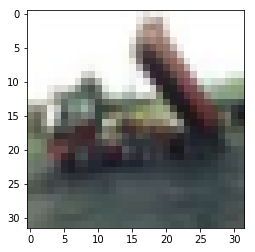

In [4]:
plt.imshow(x_train[2,:,:,:])

## Datapreprocessing

We need to scale the input pixel values which are spread out between 0-255 to 0-1
<br>
Link for more elaborate explaination https://www.youtube.com/watch?v=FDCfw-YqWTE by Andrew Ng
<br>
This normalization step allows our features to be on same scale so,  thereby allowing our model to converge faster, instead of taking too many steps during optimization.

In [5]:
x_train_N = x_train/255
x_test_N = x_test/255

We need to convert Y to a one_hot vector

In [6]:
def one_hot(labels):
    m = labels.shape[0]
    num_classes = 10
    zero_vector = np.zeros((m,num_classes))
    for i in range(0,m):
        zero_vector[i,labels[i]] = 1
    return zero_vector
y_train_H = one_hot(y_train)
y_test_H = one_hot(y_test)

In [7]:
print(y_train_H.shape)
print(y_test_H.shape)

(50000, 10)
(10000, 10)


Creates two placeholder X (for passing images) an edge in out TF graph and Y (labels of those corresponding images) another edge in our TF computation graph 

In [8]:
def create_placeholders(n_H, n_W, n_C, n_y):
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C])
    Y = tf.placeholder(tf.float32, [None, n_y])
    #Here None denotes the number of input examples
    # n_H, N_W, and n_C are image height, width and number of channels 
    # n_y is number of classes of images
    return X, Y

## Architecture of CNN

The entire model of our conv-net follows conv->conv->pool structure that is every two conv layers are follwed by a pooling layer


The input image fed into the CNN is first fed in to
<br>
1. Convolution layer comprising of 3x3x3 filters, 16 in number followed by Relu activation.
<br>
2. Convolution layer comprising of 3x3x3 filters, 32 in number followed by Relu activation.
<br>
3. Max pooling by 2x2 filters with stride 2
    * Dropout Layer
    * Batch normalization layer
<br>
4. Convolution layer comprising of 3x3x3 filters, 32 in number followed by Relu activation.
<br>
5. Convolution layer comprising of 3x3x3 filters, 64 in number followed by Relu activation.
<br>
6. Max pooling by 2x2 filters with stride 2
    * Dropout Layer
    * Batch normalization layer
<br>
7. Flattening 3D output of the previous layer 
<br>
8. Fully connected layer of 256 units followed by Relu activation
    * Dropout Layer
<br>
9. Fully connected layer of 10 units.

Firstly we initialize our filters, these are tensor flow variables as they are subjected to change while training
<br>
We use Xavier initialization to initialize our filters

In [9]:
def random_initialize():
    w1 = tf.get_variable("w1", [3, 3, 3, 16], initializer =tf.contrib.layers.xavier_initializer())
    w2 = tf.get_variable("w2", [3, 3, 16, 32], initializer =tf.contrib.layers.xavier_initializer())
    w3 = tf.get_variable("w3", [3, 3, 32, 32], initializer =tf.contrib.layers.xavier_initializer())
    w4 = tf.get_variable("w4", [3, 3, 32, 64], initializer =tf.contrib.layers.xavier_initializer())
    param = {"w1": w1, "w2": w2, "w3": w3, "w4": w4}
    return param

### Forward Propagation
All the convolution filters use SAME padding so the height and width of the image or previous layer output remain unchanged.
<br>
We use max pooling layer with Valid padding so the height and width of previous layer become half - due use of 2x2 filters-.
<br>
keep_prob_cnn and keep_prob_fully_connected are drop out probabilities of convolution layers and fully connected layer respectivelty

In [10]:
def forward_propagation(X, params, keep_prob_cnn, keep_prob_fully_connected):
    w1 = params["w1"]
    w2 = params["w2"]
    w3 = params["w3"]
    w4 = params["w4"]
    #l1
    z1 = tf.nn.conv2d(X, w1, strides = [1,1,1,1], padding = 'SAME')
    a1 = tf.nn.relu(z1)
    #l2
    z2 = tf.nn.conv2d(a1, w2, strides = [1,1,1,1], padding = 'SAME')
    a2 = tf.nn.relu(z2)
    p2 = tf.nn.max_pool(a2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    drop1 = tf.nn.dropout(p2, keep_prob_cnn)
    b2 = tf.layers.batch_normalization(drop1)
    #l3
    z3 = tf.nn.conv2d(b2, w3, strides = [1,1,1,1], padding = 'SAME')
    a3 = tf.nn.relu(z3)
    #l4
    z4 = tf.nn.conv2d(a3, w4, strides = [1,1,1,1], padding = 'SAME')
    a4 = tf.nn.relu(z4)
    p4 = tf.nn.max_pool(a4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    drop2 = tf.nn.dropout(p4, keep_prob_cnn)
    b4 = tf.layers.batch_normalization(p4)
    #fully connected
    flat = tf.contrib.layers.flatten(b4)
    a5 = tf.contrib.layers.fully_connected(flat, 256, activation_fn=tf.nn.relu)
    drop3 = tf.nn.dropout(a5, keep_prob_fully_connected)
    a6 = tf.contrib.layers.fully_connected(drop3, 10, activation_fn=None)
    return a6

The softmax loss:
<br>
Here a6 is the output of forward propagation(unscaled)
<br>
Y is the true lanbel (one_hot vector)

In [11]:
def cost_function(a6, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = a6, labels = Y))
    return cost

Due to memory constarints we divide our 50000 training examples into batches of 64 (Total of ~782 batches)
<br>
Number of batches are determined by floor(m/MiniBatchSize) 
<br>
The last batch will be comprised f remaining examples (m - NumberOfMiniBatches*ExamplesPerMinibatch)
<br>
At each instant minibatches are samples randomly

In [12]:
def create_minbatches(X, Y, mini_batchsize = 64):
    m = X.shape[0]
    permutation = list(np.random.permutation(m))
    shuffle_X = X[permutation, :,:,:]
    shuffle_Y = Y[permutation, :]
    
    minibatches = []
    num_minibatches = math.floor(m/mini_batchsize)
    for i in range(0, num_minibatches):
        mini_X = shuffle_X[i*mini_batchsize: (i+1)*mini_batchsize, :, :, :]
        mini_Y = shuffle_Y[i*mini_batchsize: (i+1)*mini_batchsize, :]
        minibatch = (mini_X, mini_Y)
        minibatches.append(minibatch)
    if m%mini_batchsize !=0
        mini_X = shuffle_X[mini_batchsize*num_minibatches: m, :, :, :]
        mini_Y = shuffle_Y[mini_batchsize*num_minibatches: m, :]
        minibatch = (mini_X, mini_Y)
        minibatches.append(minibatch)
    return minibatches

### Main Model
I used AdamOptimizer as our update rule (GD or MU can be used but they are slow when comapared to adam)
<br>
For every 200 minibatches we print the cost and training accuracy just to keep track of our progress instead of waiting for 1 epoch
<br>
Learning Rate is 0.002 and the training continues for 10 epochs
<br>
After training is done we check the accuracy of our model on test set

In [13]:
def model(x_train, y_train, x_test, y_test):
    
    ops.reset_default_graph() # when we rerun graph does not start from previous point
    lr = 0.002
    minibatch_size = 64
    keep_prob_cnn = 0.25
    keep_prob_fully_connected = 0.5
    
    (m, n_H, n_W, n_C) = x_train.shape
    n_y = y_train.shape[1]
    X, Y = create_placeholders(n_H, n_W, n_C, n_y)
    
    parameters = random_initialize()
    
    out = forward_propagation(X, parameters, keep_prob_cn, keep_prob_fully_connectedn)
    
    cost = cost_function(out, Y)
    loss = []
    
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        
        sess.run(init)
        
        num_mini = int(m/minibatch_size)
        
        for epoch in range(0,10):
            
            minibatches = create_minbatches(x_train, y_train, mini_batchsize = 64)
            loss_ep = 0
            k=0
            
            for minibatch in minibatches:
                (mini_X, mini_Y) = minibatch
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: mini_X, Y: mini_Y})
                loss_ep += temp_cost/num_mini
                if k%200 ==0:
                    print("The cost after "+str(k+1)+ " minibatches in  epoch "+ str(epoch)+" is "+str(temp_cost))
                    prediction = tf.argmax(out, 1)
                    p_equal = tf.equal(prediction, tf.argmax(Y, 1))
                    accuracy = tf.reduce_mean(tf.cast(p_equal, "float"))
                    train_accuracy = accuracy.eval({X: mini_X, Y: mini_Y})
                    print("The train accuracy is "+str(train_accuracy))
                k+=1
                
            loss.append(loss_ep)
            print("Total Loss"+ str(loss_ep))
        
        keep_prob_cnn = 1
        keep_prob_fully_connected = 1
        out1 = forward_propagation(X, parameters, keep_prob_cn, keep_prob_fully_connectedn)
        prediction = tf.argmax(out1, 1)
        p_equal = tf.equal(prediction, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(p_equal, "float"))
        test_accuracy = accuracy.eval({X: x_test[0:100,:,:,:], Y: y_test[0:100,:]})
        print("The test set accuracy is "+str(test_accuracy))
        
    return parameters

In [14]:
params = model(x_train_N, y_train_H, x_test_N, y_test_H)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

The cost after 1 minibatches in  epoch 0 is 2.2931511
The train accuracy is 0.15625
The cost after 201 minibatches in  epoch 0 is 1.7663238
The train accuracy is 0.328125
The cost after 401 minibatches in  epoch 0 is 1.5289774
The train accuracy is 0.484375
The cost after 601 minibatches in  epoch 0 is 1.5111376
The train accuracy is 0.421875
Total Loss1.6276597622567321
The cost after 1 minibatches in  epoch 1 is 1.4455782
The train accuracy is 0.484375
The cost after 201 minibatches in  epoch 1 is 1.3074039
The train accuracy is 0.5625
The cost after 401 minibatches in  epoch 1 is 1.4768271
The train accuracy is 0.53125
The cost after 601 minibatches in  epoch 1 is 1.2815166
The train accuracy is 0.46875
Total Loss1.2892301039109613
The cost after 1 minibatches in  epoch 2 is 1.3946996
The train

So, finally the test accuracy was around 68%. As we can see that total loss was still decreasing significatly this test accuarcy can be improved by further continuing the training process .
<br>
Due to hardware constraints I stopped my training after 10 epochs (It took 7hrs to run 10 epochs on my i3 processor with 4Gb of RAM)
